In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
sns.set()

os.chdir('../..')

DATA = Path('data')
RAW  = DATA/'raw'
PROCESSED = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)

In [41]:
%%time
product = pd.read_csv(RAW/'productid_category.csv', low_memory=False)
train_tracking = pd.read_csv(RAW/'train_tracking.csv', low_memory=False)
test_tracking  = pd.read_csv(RAW/'test_tracking.csv', low_memory=False)
train_session = pd.read_csv(RAW/'train_session.csv', low_memory=False)
test_session  = pd.read_csv(RAW/'random_submission.csv', low_memory=False)

CPU times: user 1min 7s, sys: 8.05 s, total: 1min 15s
Wall time: 1min 15s


In [4]:
train.shape, test.shape, train_session.shape, test_session.shape, product.shape

((1355095, 31), (908233, 31), (133123, 2), (88750, 2), (10635919, 4))

In [10]:
test.drop_duplicates('sid').shape, test_session.shape, test.shape

((88750, 31), (88750, 2), (908233, 31))

In [11]:
train.drop_duplicates('sid').shape, train_session.shape, train.shape

((133123, 31), (133123, 2), (1355095, 31))

In [14]:
train_events = train.groupby('sid').size()
test_events  = test.groupby('sid').size()

In [125]:
train_tracking.sku.nunique()

114560

In [19]:
train_events.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    133123.000000
mean         10.179270
std          14.249718
min           3.000000
1%            3.000000
10%           3.000000
25%           4.000000
50%           6.000000
75%          11.000000
90%          21.000000
99%          67.000000
max         951.000000
dtype: float64

In [20]:
test_events.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    88750.000000
mean        10.233611
std         17.898086
min          3.000000
1%           3.000000
10%          3.000000
25%          4.000000
50%          6.000000
75%         11.000000
90%         21.000000
99%         66.000000
max       3361.000000
dtype: float64

In [31]:
train_events[train_events>100].shape, test_events[test_events>100].shape

((454,), (310,))

## Generate validation set

In [34]:
from sklearn.model_selection import train_test_split

def generate_validation_set(session, tracking, test_size=0.1, seed=42):
    trn_session, val_session = train_test_split(session, test_size=test_size, random_state=seed, shuffle=True)
    trn_session_ids, val_session_ids = set(trn_session.sid), set(val_session.sid)
    trn_tracking = tracking[tracking.sid.apply(lambda x: x in trn_session_ids)]
    val_tracking = tracking[tracking.sid.apply(lambda x: x in val_session_ids)]
    return trn_session, trn_tracking, val_session, val_tracking

In [35]:
%%time
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(train_session, train, test_size=0.1, seed=42)

CPU times: user 1.06 s, sys: 447 ms, total: 1.51 s
Wall time: 1.51 s


In [38]:
train.shape, test.shape, train_session.shape, test_session.shape

((1355095, 31), (908233, 31), (133123, 2), (88750, 2))

In [37]:
trn_tracking.shape, val_tracking.shape, trn_session.shape, val_session.shape

((1219083, 31), (136012, 31), (119810, 2), (13313, 2))

In [39]:
trn_ids = set(trn_tracking.sid)
val_ids = set(val_tracking.sid)

In [40]:
len(trn_ids.intersection(val_ids))

0

In [43]:
len(test_session) / (len(test_session) + len(train_session))

0.4000036056663046

## Plots

In [44]:
train_tracking.head()

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified
0,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'JHRfp5ydSvpIOBk7rqeHaep6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,CAROUSEL
1,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'V8buGT/FybKwREEFPwo8vup6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:11.179637600,CAROUSEL
2,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,oJTJfSrMpHk5VzZyB9rtEw==,[{'sku': 'Acr3ieqo6rTn9cDfXO5/4up6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:13.132755800,CAROUSEL
3,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'MlIOsc6DgaqG/BO9BBfEf+p6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:02:17.397333300,CAROUSEL
4,KeKjpi6re4QRYxl76E8sLPJHxRCeapb4sb69s5hmPCV+Jn...,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,875,1266,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,PA


In [45]:
train_tracking[train_tracking.type=='SEARCH'].head()

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified
7,KeKjpi6re4QRYxl76E8sLPJHxRCeapb4sb69s5hmPCV+Jn...,SEARCH,TpqhsVcWFJqvXnbsPSsyROp6NPTGBfCKCRdXNRSP70U=,2.0,17.0,1.0,NaN,"[{'sku': '3YwPYglDjWDuNPjrAXUyFA==', 'offerid'...","['3YwPYglDjWDuNPjrAXUyFA==', 'kt3FWu1Y+Jps3OFl...",875,1266,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:03:13.467327800,SEARCH
11,e2Qk4mY2coR7ccDjFb14arn512Jw7rKn9TF5QFOeoQw6Ct...,SEARCH,pbi/gk++V0HCOv2T0IpIEQ==,3.0,174490.0,1.0,NaN,[{'sku': 'SRBZJmU4XN8uZGrNSnHJp+p6NPTGBfCKCRdX...,['SRBZJmU4XN8uZGrNSnHJp+p6NPTGBfCKCRdXNRSP70U=...,649,1024,TvwEXZP7a45jv48s/MIm/w==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5QmFu8A6HVU6cIT8YqnAZg==,0 days 00:00:00.000000000,SEARCH
12,e2Qk4mY2coR7ccDjFb14arn512Jw7rKn9TF5QFOeoQw6Ct...,SEARCH,n3nVKaET596gn4ITKpOb5yzsLej2qyAcvWLFepzx+pw=,5.0,1700.0,1.0,NaN,[{'sku': 'jcfZKbG6bk8V5uw+fRXC8Op6NPTGBfCKCRdX...,['jcfZKbG6bk8V5uw+fRXC8Op6NPTGBfCKCRdXNRSP70U=...,649,1024,TvwEXZP7a45jv48s/MIm/w==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5QmFu8A6HVU6cIT8YqnAZg==,0 days 00:00:22.974930300,SEARCH
13,e2Qk4mY2coR7ccDjFb14arn512Jw7rKn9TF5QFOeoQw6Ct...,SEARCH,n3nVKaET596gn4ITKpOb5yzsLej2qyAcvWLFepzx+pw=,5.0,1700.0,2.0,NaN,[{'sku': '3xkTRc05LXNw5gSQoSt7++p6NPTGBfCKCRdX...,['3xkTRc05LXNw5gSQoSt7++p6NPTGBfCKCRdXNRSP70U=...,729,1024,TvwEXZP7a45jv48s/MIm/w==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5QmFu8A6HVU6cIT8YqnAZg==,0 days 00:01:14.070494100,SEARCH
14,e2Qk4mY2coR7ccDjFb14arn512Jw7rKn9TF5QFOeoQw6Ct...,SEARCH,n3nVKaET596gn4ITKpOb5yzsLej2qyAcvWLFepzx+pw=,5.0,1700.0,3.0,NaN,[{'sku': 'buibjIyaVM4wx5qbYEpQI+p6NPTGBfCKCRdX...,['buibjIyaVM4wx5qbYEpQI+p6NPTGBfCKCRdXNRSP70U=...,729,1024,TvwEXZP7a45jv48s/MIm/w==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5QmFu8A6HVU6cIT8YqnAZg==,0 days 00:01:29.935315900,SEARCH


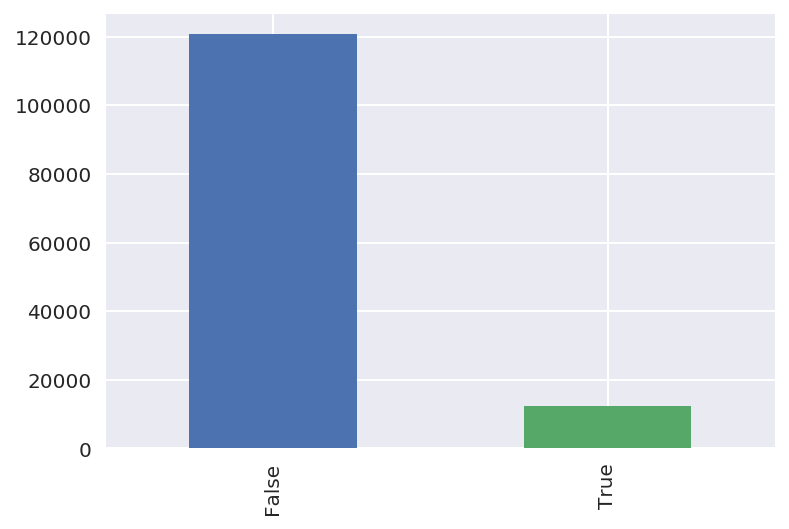

In [12]:
session.target.value_counts().plot.bar()

In [15]:
train_ids = set(train.sid.unique())
test_ids = set(test.sid.unique())

In [16]:
len(train_ids), len(test_ids), len(train_ids.intersection(test_ids))

(133123, 88750, 0)

In [18]:
train.type_simplified.value_counts()

SEARCH              463181
CAROUSEL            341943
PRODUCT             218022
LIST_PRODUCT        105838
PA                  103794
SHOW_CASE            75786
ADD_TO_BASKET        41814
PURCHASE_PRODUCT      4717
Name: type_simplified, dtype: int64

In [19]:
test.type_simplified.value_counts()

SEARCH              315068
CAROUSEL            228101
PRODUCT             145360
LIST_PRODUCT         69580
PA                   68848
SHOW_CASE            50101
ADD_TO_BASKET        28092
PURCHASE_PRODUCT      3083
Name: type_simplified, dtype: int64

In [54]:
np.log(len(train_session))

11.799028791858795

In [61]:
train.groupby('type_simplified')['type'].size()

type_simplified
ADD_TO_BASKET        41814
CAROUSEL            341943
LIST_PRODUCT        105838
PA                  103794
PRODUCT             218022
PURCHASE_PRODUCT      4717
SEARCH              463181
SHOW_CASE            75786
Name: type, dtype: int64

In [66]:
train.groupby(['type_simplified', 'type']).size()

type_simplified   type                          
ADD_TO_BASKET     ADD_TO_BASKET_CAROUSEL              5863
                  ADD_TO_BASKET_LP                    3341
                  ADD_TO_BASKET_LR                   31368
                  ADD_TO_BASKET_PA                     472
                  ADD_TO_BASKET_SHOW_CASE              770
CAROUSEL          CAROUSEL                          341943
LIST_PRODUCT      LIST_PRODUCT                      105838
PA                PA                                103794
PRODUCT           PRODUCT_CAROUSEL                   51681
                  PRODUCT_LP                         20807
                  PRODUCT_LR                        128390
                  PRODUCT_PA                          7344
                  PRODUCT_SHOW_CASE                   9800
PURCHASE_PRODUCT  PURCHASE_PRODUCT_CAROUSEL            318
                  PURCHASE_PRODUCT_LP                  158
                  PURCHASE_PRODUCT_LR                 1790
       

In [69]:
train.head()

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified
0,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'JHRfp5ydSvpIOBk7rqeHaep6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,CAROUSEL
1,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'V8buGT/FybKwREEFPwo8vup6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:11.179637600,CAROUSEL
2,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,oJTJfSrMpHk5VzZyB9rtEw==,[{'sku': 'Acr3ieqo6rTn9cDfXO5/4up6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:13.132755800,CAROUSEL
3,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'MlIOsc6DgaqG/BO9BBfEf+p6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:02:17.397333300,CAROUSEL
4,KeKjpi6re4QRYxl76E8sLPJHxRCeapb4sb69s5hmPCV+Jn...,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,875,1266,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,PA


In [88]:
uniques = train_tracking.groupby('sid')['device'].nunique()

In [89]:
uniques.value_counts()

1    132714
0       355
2        54
Name: device, dtype: int64

In [91]:
uniques[uniques==2].head()

sid
+eeuunvJR8X0eRetlSdfydmRcYu9czbCvKhS6rCaflA3dF2+yLhVc1uiyyllzxDx    2
+z2ia3CokUUayymCYUNQcX50uBLg9XqNmJ2NukCUse8EC9dpg3mgcnS21pgSQbvD    2
0pbnl8cffd+Vh5Ddn7GUlG3o2IW5lEQMe9m4JTUklbIWT9aYFLxZ3znd5UmjCYd4    2
3NVaxmawzrj8cArnVpMoHykdDdCtDcmW6qMmmKQSjzy3x75hgjbBxkMUwzJk5OQe    2
463l6wwISezxWqcYpZH0Wrwbss7DtnLtPtUoPdubH8MD537sRDTM6WuBc06Y8bYb    2
Name: device, dtype: int64

In [93]:
uniques = train_tracking.groupby('sid')['rh'].nunique()

In [84]:
uniques[uniques==18]

sid
S9/rDIoJCLC1cdtTsc+h7Nj2qqP0L939BrznM8T+veGtadqzdYV+8tmITMPQ54zf    18
Name: rh, dtype: int64

In [86]:
common_cols = ['rh', 'rw', 'device', 'duration', 'siteid']

In [94]:
uniques = train_tracking.groupby('sid')['siteid'].nunique()
uniques.value_counts()

1    133116
2         7
Name: siteid, dtype: int64

In [95]:
uniques[uniques==2]

sid
+eeuunvJR8X0eRetlSdfydmRcYu9czbCvKhS6rCaflA3dF2+yLhVc1uiyyllzxDx    2
BEsT7Nu4iVU0mONGaXywucRGIiEo1+jJAnN3ab8QBgd129JfovC7FwtYDnjTdFPm    2
DJkfzKv90I9SyDLNQhoKVxjMQLeUG/fkM9dlN0qoXTLfs2BdyY0g5RvTuazfLghA    2
UkXhhB+f5/24PZagrXmFyg/9i9Be6VkD9uBXBoDCWfnpfwm8lfOAnoTET0yNAX6a    2
bXcjs6QvHFcEDfXrx03C/1iOznBkSlKy5qs9Q9Loj5LEP3nWLfmcaQfJYKF+TH35    2
eo6D8mbSuY49HQT2g46ftnBDyZGYadHDJ30zSK/ccr9n27y6a7PXqGFqSPkkvaQ5    2
ynEyPYeXUYXSIAZyXWXtCtx03GsMlDVgvBlZFRis3Dkc6JZ/wiCJf+JuwPCdbweU    2
Name: siteid, dtype: int64

In [96]:
train_tracking[train_tracking.sid=='+eeuunvJR8X0eRetlSdfydmRcYu9czbCvKhS6rCaflA3dF2+yLhVc1uiyyllzxDx'][common_cols]

,rh,rw,device,duration,siteid
600883,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:00:00.000000000,cF8tnO1rK7fIBxVIs+AW4w==
600884,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:00:00.812517300,cF8tnO1rK7fIBxVIs+AW4w==
600885,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:00:06.139120700,cF8tnO1rK7fIBxVIs+AW4w==
600886,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:04:30.308870400,cF8tnO1rK7fIBxVIs+AW4w==
600887,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:04:30.887039600,cF8tnO1rK7fIBxVIs+AW4w==
600888,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:04:43.622085400,cF8tnO1rK7fIBxVIs+AW4w==
600889,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:04:44.093188500,cF8tnO1rK7fIBxVIs+AW4w==
600890,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:05:17.451711300,cF8tnO1rK7fIBxVIs+AW4w==
600891,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:05:17.989279400,cF8tnO1rK7fIBxVIs+AW4w==
600892,919,1680,9DP4L/tKWLkYUystNndR3g==,0 days 00:05:25.407499700,cF8tnO1rK7fIBxVIs+AW4w==


In [100]:
counts = train_tracking.groupby('sid')['sku'].nunique()

In [107]:
product[product.product_id=='Zw92hEmaaA7dQb2cgpn/Jg==']

,product_id,category_product_id_level1,category_product_id_level2,category_product_id_level3


In [103]:
counts.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    133123.000000
mean          1.488909
std           2.366719
min           0.000000
1%            0.000000
10%           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
90%           3.000000
99%          10.000000
max         212.000000
Name: sku, dtype: float64

In [108]:
counts[counts==0].head()

sid
++0tYP9PmT6jX9O1WjUhWd7w3hWV6xSRMBOdA7HMoBukKsXCbSII2Ryt9Jb259+X    0
++Kcd+rVnIXmOkKeKE+M0oCYvYw+8To+StAbZ2FZjrTi1dj9PkVNIUHD763tDC8m    0
++LM/k0USZn/oKPtOn91nPO/GQ0qOzLNor5a1sFHgWBdxFbHbIT+3JK8T5/QNyVk    0
++XVWmD6fjYgO+ZVuZd/NbFwvPuVFKRXcxkMDF9/cwzSiQfpubZ1eMTznfqrtv9z    0
++YL575kD8MMqh9Eu4fMvnz9j0+zb34G02VC6t18KpmMApD+eAUebbFgtsl78gIu    0
Name: sku, dtype: int64

In [116]:
common_cols = ['rh', 'rw', 'device', 'duration', 'siteid', 'type', 'type_simplified', 'target']

In [115]:
train_tracking = pd.merge(train_tracking, train_session, on='sid', how='left')

In [119]:
def add_num_skus(session, tracking):
    sku_counts = train_tracking.groupby('sid')['sku'].nunique()
    session['num_skus'] = session.sid.map(sku_counts)

In [124]:
train_session.head()

,sid,target,num_skus
0,U6clt0UYaQB7vJQFmSWYymsAfwmT9SMhrm2oXQ8TC5M8mf...,False,1
1,0qRbLkxeOjeEo6CtxtB6VI8FNPt4Vl8niySzZLqSWiQOka...,False,3
2,cnCRGomfPqEWuhMZkA0RQfvTQiwVoyHXUqvqnPCutVouFO...,False,1
3,zBwrofN0r2ps9u/UCUS134SiZIqB+UgIEr0MZGHzksqR4f...,False,0
4,Kbr60r9eaX/ENOJ81R1YBxfwrEohoxyQI9Ma0fODsS+/XN...,False,0


In [123]:
add_num_skus(train_session, train_tracking)

In [118]:
train_tracking[train_tracking.sid=='++XVWmD6fjYgO+ZVuZd/NbFwvPuVFKRXcxkMDF9/cwzSiQfpubZ1eMTznfqrtv9z'][common_cols].head()

,rh,rw,device,duration,siteid,type,type_simplified,target
436395,593,1366,9DP4L/tKWLkYUystNndR3g==,0 days 00:00:00.000000000,cF8tnO1rK7fIBxVIs+AW4w==,PA,PA,False
436396,593,1366,9DP4L/tKWLkYUystNndR3g==,0 days 00:00:09.752457400,cF8tnO1rK7fIBxVIs+AW4w==,SHOW_CASE,SHOW_CASE,False
436397,593,1366,9DP4L/tKWLkYUystNndR3g==,0 days 00:02:32.066775400,cF8tnO1rK7fIBxVIs+AW4w==,SHOW_CASE,SHOW_CASE,False


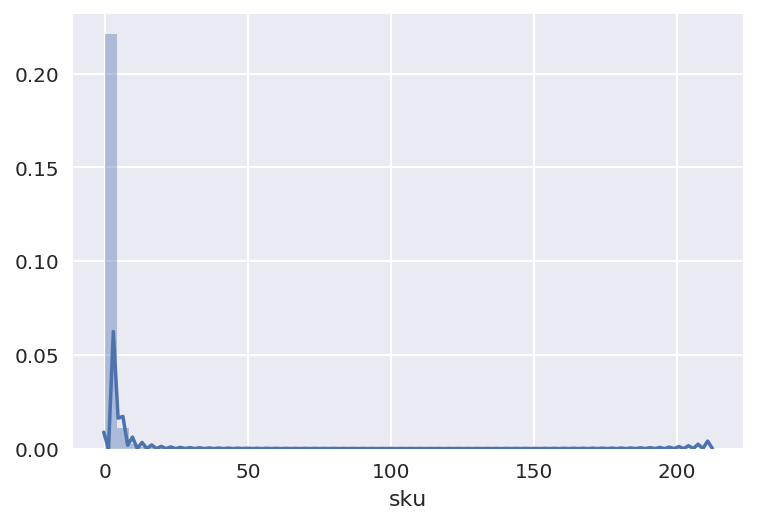

In [104]:
sns.distplot(counts)

In [99]:
train_tracking.device.unique()

array(['9DP4L/tKWLkYUystNndR3g==', 'TvwEXZP7a45jv48s/MIm/w==', nan,
       'RoFHzpnheNCA5N9hQc7Q2w=='], dtype=object)

In [ ]:
train_tracking.head()[]

In [83]:
uniques.value_counts()

1     118335
2      12773
3       1545
4        331
5         84
7         21
6         21
8          7
13         2
18         1
12         1
11         1
9          1
Name: rh, dtype: int64

In [ ]:
train.groupby(['type_simplified', 'type']).size()

In [53]:
train.type.value_counts()

SEARCH                            463181
CAROUSEL                          341943
PRODUCT_LR                        128390
LIST_PRODUCT                      105838
PA                                103794
SHOW_CASE                          75786
PRODUCT_CAROUSEL                   51681
ADD_TO_BASKET_LR                   31368
PRODUCT_LP                         20807
PRODUCT_SHOW_CASE                   9800
PRODUCT_PA                          7344
ADD_TO_BASKET_CAROUSEL              5863
ADD_TO_BASKET_LP                    3341
PURCHASE_PRODUCT_UNKNOW_ORIGIN      2369
PURCHASE_PRODUCT_LR                 1790
ADD_TO_BASKET_SHOW_CASE              770
ADD_TO_BASKET_PA                     472
PURCHASE_PRODUCT_CAROUSEL            318
PURCHASE_PRODUCT_LP                  158
PURCHASE_PRODUCT_SHOW_CASE            46
PURCHASE_PRODUCT_PA                   36
Name: type, dtype: int64

In [5]:
train[train.type_simplified=='ADD_TO_BASKET'].head()

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified
21,e2Qk4mY2coR7ccDjFb14arn512Jw7rKn9TF5QFOeoQw6Ct...,ADD_TO_BASKET_LR,NaN,NaN,0.0,0.0,NaN,NaN,NaN,649,1024,TvwEXZP7a45jv48s/MIm/w==,NaN,NaN,YUGMCNDl41ue6qX8921SsOp6NPTGBfCKCRdXNRSP70U=,jKC/bdRR/ZHDxLa7rdLxlQ==,1.0,nH9oPdOoBjQ6KgoScH5o4Q==,uoH56djbS63NN1GX6ZgtrA==,0.0,NaN,NaN,n3nVKaET596gn4ITKpOb5yzsLej2qyAcvWLFepzx+pw=,1797.0,NaN,8.0,['WzbobXgk6IbrnqSUhifIPup6NPTGBfCKCRdXNRSP70U=...,[{'sku': 'WzbobXgk6IbrnqSUhifIPup6NPTGBfCKCRdX...,5QmFu8A6HVU6cIT8YqnAZg==,0 days 00:07:06.326787800,ADD_TO_BASKET
82,knWvEQl2pZ7FKq2MItMMj4xcgFT7Zu5ekEOh9UQl7BiwaQ...,ADD_TO_BASKET_CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,655,1333,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,5BsZ9b6Vizdki7dvClF3gg==,aYvl0LeuT7EQ8zcjdALwyw==,1.0,i40+rMlxCCxz1hgpPEHVCw==,6hyMZwXwc2Lr9JuYVCnnYQ==,0.0,mildLdcmo8Loi/hRcQIhbg==,"[{'sku': '5BsZ9b6Vizdki7dvClF3gg==', 'offerid'...",NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:01:17.613142100,ADD_TO_BASKET
101,knWvEQl2pZ7FKq2MItMMj4xcgFT7Zu5ekEOh9UQl7BiwaQ...,ADD_TO_BASKET_LR,LrTsBmFs+aWCLGbpllu3mA==,1.0,463.0,1.0,NaN,NaN,NaN,655,1333,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,/a3Lwr4CEKlr3h87mm6YCw==,Y0v0WURBHmGvS7UZHuz/sQ==,1.0,i40+rMlxCCxz1hgpPEHVCw==,6hyMZwXwc2Lr9JuYVCnnYQ==,0.0,NaN,NaN,LrTsBmFs+aWCLGbpllu3mA==,463.0,NaN,1.0,"['EoOva6fcbgwJ5O3pHC92yQ==', 'MZeywptuXScmJXUz...","[{'sku': 'EoOva6fcbgwJ5O3pHC92yQ==', 'offerid'...",cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:18:29.771275300,ADD_TO_BASKET
105,knWvEQl2pZ7FKq2MItMMj4xcgFT7Zu5ekEOh9UQl7BiwaQ...,ADD_TO_BASKET_LR,M7CGVr9BnuzT2mAFNA6xCg==,4.0,447.0,1.0,NaN,NaN,NaN,655,1333,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,v0pW+tKV2kI9+3M3t5M9hup6NPTGBfCKCRdXNRSP70U=,4L4sKFrTROOSZBVV8pKjKA==,1.0,nH9oPdOoBjQ6KgoScH5o4Q==,Xt/E+xLgwjUgJZHO029NaQ==,0.0,NaN,NaN,M7CGVr9BnuzT2mAFNA6xCg==,447.0,NaN,1.0,['6DLNT4ACXnKiKJzZNpi+Qep6NPTGBfCKCRdXNRSP70U=...,[{'sku': '6DLNT4ACXnKiKJzZNpi+Qep6NPTGBfCKCRdX...,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:21:53.733075200,ADD_TO_BASKET
191,WIdRXlIhBSsdTGZIgiqozX6KpwA/HptmC2Ume1eMCDfKB/...,ADD_TO_BASKET_CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,955,1894,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,yD4GsxD/ju5VpsnXfXl25+p6NPTGBfCKCRdXNRSP70U=,IRavmfpK1j3+y4vYi2PwwQ==,1.0,nH9oPdOoBjQ6KgoScH5o4Q==,OmU4dLbx8Mx5XT9ofDnqr71OT2M+mZuOpXsKVZwvojM=,0.0,2pIahJLRm7ReKjTKi7w1jg==,[{'sku': 'yD4GsxD/ju5VpsnXfXl25+p6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:10:41.498572000,ADD_TO_BASKET


In [22]:
category.head()

,product_id,category_product_id_level1,category_product_id_level2,category_product_id_level3
0,i1t4Uq+NqhB0O4d2J/jzCA==,1387712,1388277,1394791
1,a0OxyFVArDl0UzhpmP1L5w==,13,87,6352
2,mQ+KVVCUfLKmb2Rlo/FT3A==,22,527,5945
3,KVg9N8j/cuLPkvIcSzYemw==,5,11,40
4,N9mErkxf69NX7uuqysEWGA==,2626413,2626979,2633494


In [23]:
category.category_product_id_level3.nunique(), category.category_product_id_level2.nunique(), category.category_product_id_level1.nunique()

(5110888, 5104371, 5103805)

In [25]:
train.head()

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified
0,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'JHRfp5ydSvpIOBk7rqeHaep6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,CAROUSEL
1,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'V8buGT/FybKwREEFPwo8vup6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:11.179637600,CAROUSEL
2,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,oJTJfSrMpHk5VzZyB9rtEw==,[{'sku': 'Acr3ieqo6rTn9cDfXO5/4up6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:13.132755800,CAROUSEL
3,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'MlIOsc6DgaqG/BO9BBfEf+p6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:02:17.397333300,CAROUSEL
4,KeKjpi6re4QRYxl76E8sLPJHxRCeapb4sb69s5hmPCV+Jn...,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,875,1266,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,PA


In [26]:
train.columns

Index(['sid', 'type', 'query', 'nb_query_terms', 'rcount', 'pn', 'facets',
       'products', 'dproducts', 'rh', 'rw', 'device', 'idcar', 'carproducts',
       'sku', 'offerid', 'quantity', 'stype', 'sname', 'ff', 'oidcar',
       'ocarproducts', 'oquery', 'orcount', 'ofacets', 'opn', 'odproducts',
       'oproducts', 'siteid', 'duration', 'type_simplified'],
      dtype='object')

In [30]:
train = pd.merge(train, session, how='left', on='sid')

In [31]:
train.shape

(1355095, 32)

In [32]:
train.head()

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified,target
0,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'JHRfp5ydSvpIOBk7rqeHaep6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,CAROUSEL,False
1,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'V8buGT/FybKwREEFPwo8vup6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:11.179637600,CAROUSEL,False
2,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,oJTJfSrMpHk5VzZyB9rtEw==,[{'sku': 'Acr3ieqo6rTn9cDfXO5/4up6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:13.132755800,CAROUSEL,False
3,xvmQh3WmJGKaplwGgHf4o1MNKg2/6IpkbKNh4nnwZibi3f...,CAROUSEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1094,1920,9DP4L/tKWLkYUystNndR3g==,IIWYMIbWc/3MM8J2jDfSJw==,[{'sku': 'MlIOsc6DgaqG/BO9BBfEf+p6NPTGBfCKCRdX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:02:17.397333300,CAROUSEL,False
4,KeKjpi6re4QRYxl76E8sLPJHxRCeapb4sb69s5hmPCV+Jn...,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,875,1266,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:00:00.000000000,PA,False


In [41]:
train[train.target==False].type_simplified.value_counts(normalize=True).sort_index()

ADD_TO_BASKET       0.025775
CAROUSEL            0.248128
LIST_PRODUCT        0.082531
PA                  0.079125
PRODUCT             0.160692
PURCHASE_PRODUCT    0.002334
SEARCH              0.342583
SHOW_CASE           0.058834
Name: type_simplified, dtype: float64

In [42]:
train[train.target==True].type_simplified.value_counts(normalize=True).sort_index()

ADD_TO_BASKET       0.063179
CAROUSEL            0.279122
LIST_PRODUCT        0.049948
PA                  0.060506
PRODUCT             0.162156
PURCHASE_PRODUCT    0.010776
SEARCH              0.336875
SHOW_CASE           0.037439
Name: type_simplified, dtype: float64

In [46]:
train.type.value_counts()

SEARCH                            463181
CAROUSEL                          341943
PRODUCT_LR                        128390
LIST_PRODUCT                      105838
PA                                103794
SHOW_CASE                          75786
PRODUCT_CAROUSEL                   51681
ADD_TO_BASKET_LR                   31368
PRODUCT_LP                         20807
PRODUCT_SHOW_CASE                   9800
PRODUCT_PA                          7344
ADD_TO_BASKET_CAROUSEL              5863
ADD_TO_BASKET_LP                    3341
PURCHASE_PRODUCT_UNKNOW_ORIGIN      2369
PURCHASE_PRODUCT_LR                 1790
ADD_TO_BASKET_SHOW_CASE              770
ADD_TO_BASKET_PA                     472
PURCHASE_PRODUCT_CAROUSEL            318
PURCHASE_PRODUCT_LP                  158
PURCHASE_PRODUCT_SHOW_CASE            46
PURCHASE_PRODUCT_PA                   36
Name: type, dtype: int64

In [52]:
train[train['query'].notnull()].sample(5)

,sid,type,query,nb_query_terms,rcount,pn,facets,products,dproducts,rh,rw,device,idcar,carproducts,sku,offerid,quantity,stype,sname,ff,oidcar,ocarproducts,oquery,orcount,ofacets,opn,odproducts,oproducts,siteid,duration,type_simplified
127297,C2kb6e0RYJgvhTSMDCKOt13YmMzOPfGDgfg8Vn2iKTdEm4...,SEARCH,ZVfFwYjFNizh3YGd5A0X7c7W0lVXDPJGyn6DaUKRsOs=,3.0,27.0,1.0,NaN,"[{'sku': 'J729lWvMd40gUiYxuMAl3A==', 'offerid'...","['J729lWvMd40gUiYxuMAl3A==', 'U33UXiqPaT+JXDhb...",769,1600,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 03:47:58.525571500,SEARCH
706048,cJIgcRB7CMn5XqWmxLGXcxVVNBLTapTiLX9HUx9jV+fKK4...,SEARCH,x3gQHG1zwVp5YnC6kZUibg==,1.0,3037.0,2.0,NaN,[{'sku': 'pKEpbV+f8RHlGaUW3qmPA+p6NPTGBfCKCRdX...,['pKEpbV+f8RHlGaUW3qmPA+p6NPTGBfCKCRdXNRSP70U=...,728,1024,TvwEXZP7a45jv48s/MIm/w==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5QmFu8A6HVU6cIT8YqnAZg==,0 days 00:07:26.569877600,SEARCH
1273400,4OxZvA6cUegfuQ4Cq0dwaDs09+9R6QY8oVClB+a9VKB6qq...,SEARCH,XDldiEXinC+AyfRlIvAfOg==,1.0,21.0,1.0,NaN,[{'sku': 'UNwe+UsGhr+K5pHUG7r2F+p6NPTGBfCKCRdX...,['UNwe+UsGhr+K5pHUG7r2F+p6NPTGBfCKCRdXNRSP70U=...,961,1920,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:20:56.778696300,SEARCH
1348362,RonqzQgwGetNDEZL1ODt38it4/blpWcdcXuP66xEx/chxS...,SEARCH,2GQxuzjVo2zy+8++35ht3Q==,2.0,681.0,1.0,NaN,[{'sku': 'vaCszlf35dy0HHnm+n+i8ep6NPTGBfCKCRdX...,['vaCszlf35dy0HHnm+n+i8ep6NPTGBfCKCRdXNRSP70U=...,763,1600,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:01:41.508667400,SEARCH
1235003,0JlYgyMJNIOlz+PGRaQRDK9CVj5JVMUGwgIcHwYk0b9Tl6...,SEARCH,LU+en2R7PtJSdj9MOWj3Aw==,2.0,14982.0,5.0,NaN,[{'sku': 'eiBBZ1if0jpZidYWARperOp6NPTGBfCKCRdX...,['eiBBZ1if0jpZidYWARperOp6NPTGBfCKCRdXNRSP70U=...,662,1366,9DP4L/tKWLkYUystNndR3g==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cF8tnO1rK7fIBxVIs+AW4w==,0 days 00:06:06.193466500,SEARCH
